# Recommendation System

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import random
from scipy import sparse
from scipy.sparse import csr_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.decomposition import TruncatedSVD

In [2]:
df=pd.read_csv('/kaggle/input/amazon-ratings/ratings_Beauty.csv')
print('Shape: ',df.shape)
df.head()

Shape:  (2023070, 4)


,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


## Data Analysis

### ->Identifying Duplicates in data

In [3]:
duplicates = df.duplicated(["UserId","ProductId", "Rating", "Timestamp"]).sum()
print(' Duplicate records: ',duplicates)

 Duplicate records:  0


### ->Unique features

In [4]:
print('unique users:',len(df.UserId.unique()))
print('unique products:',len(df.ProductId.unique()))
print("total ratings: ",df.shape[0])

unique users: 1210271
unique products: 249274
total ratings:  2023070


### ->Checking for Nan values

In [5]:
df.isnull().any()

UserId       False
ProductId    False
Rating       False
Timestamp    False
dtype: bool

# ### -> Analysing the number of rated products per user:

In [6]:
products_user= df.groupby(by = "UserId")["Rating"].count().sort_values(ascending =False)
products_user.head()

UserId
A3KEZLJ59C1JVH    389
A281NPSIMI1C2R    336
A3M174IC0VXOS2    326
A2V5R832QCSOMX    278
A3LJLRIZL38GG3    276
Name: Rating, dtype: int64

### ->Analysing the Rating number per product:

In [7]:
product_rated = df.groupby(by = "ProductId")["Rating"].count().sort_values(ascending = False)
product_rated.head()



ProductId
B001MA0QY2    7533
B0009V1YR8    2869
B0043OYFKU    2477
B0000YUXI0    2143
B003V265QW    2088
Name: Rating, dtype: int64

## Data Visualizing and Cleaning

In [8]:
rated_users=df.groupby("UserId")["ProductId"].count().sort_values(ascending=False)
print(rated_users)

UserId
A3KEZLJ59C1JVH           389
A281NPSIMI1C2R           336
A3M174IC0VXOS2           326
A2V5R832QCSOMX           278
A3LJLRIZL38GG3           276
                        ... 
A3BQ47C773YMU1             1
A3BQ3Y37XL049D             1
A3BQ3NGQ3JJBR3             1
A3BQ3BW37JKZZ4             1
A00008821J0F472NDY6A2      1
Name: ProductId, Length: 1210271, dtype: int64


In [9]:
print('Number of users rated atleast 5 prodcuts:',rated_users[rated_users>=5].count())
print('Number of users rated atleast 4 prodcuts:',rated_users[rated_users>=4].count())
print('Number of users rated atleast 3 prodcuts:',rated_users[rated_users>=3].count())
print('Number of users rated atleast 2 prodcuts:',rated_users[rated_users>=2].count())


Number of users rated atleast 5 prodcuts: 52374
Number of users rated atleast 4 prodcuts: 82659
Number of users rated atleast 3 prodcuts: 146995
Number of users rated atleast 2 prodcuts: 322870


In [10]:
users=list(rated_users[:rated_users[rated_users>=5].count()].index)
df=df[df['UserId'].isin(users)]


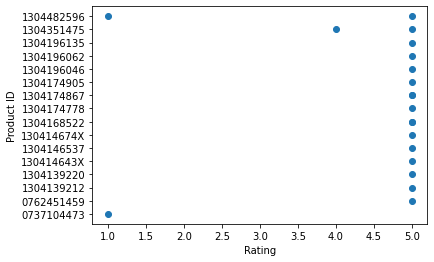

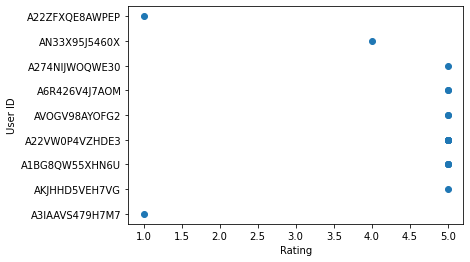

In [11]:
rated_products=df.groupby("ProductId")["UserId"].count().sort_values(ascending=False)

plt.scatter(x=df.Rating[:20], y=df.ProductId[:20])
plt.xlabel('Rating')
# Set the y axis label of the current axis.
plt.ylabel('Product ID')

plt.show()

plt.scatter(x=df.Rating[:20], y=df.UserId[:20])
plt.xlabel('Rating')
# Set the y axis label of the current axis.
plt.ylabel('User ID')

plt.show()

In [12]:
print('Number of products with minimum of 5 reviews/ratings:',rated_products[rated_products>5].count())
print('Number of products with minimum of 4 reviews/ratings:',rated_products[rated_products>4].count())
print('Number of products with minimum of 3 reviews/ratings:',rated_products[rated_products>3].count())
print('Number of products with minimum of 2 reviews/ratings:',rated_products[rated_products>2].count())
print('Number of products with minimum of 1 reviews/ratings:',rated_products[rated_products>1].count())


Number of products with minimum of 5 reviews/ratings: 15873
Number of products with minimum of 4 reviews/ratings: 19369
Number of products with minimum of 3 reviews/ratings: 24746
Number of products with minimum of 2 reviews/ratings: 33973
Number of products with minimum of 1 reviews/ratings: 53414


In [13]:
products=list(rated_products[:rated_products[rated_products>5].count()].index)
df=df[df['ProductId'].isin(products)]
products[:5]


['B0043OYFKU', 'B000ZMBSPE', 'B004OHQR1Q', 'B000142FVW', 'B0069FDR96']

In [14]:
u_v=df["UserId"].values
n_v=[]
for i in tqdm(range(df.shape[0])):
    n_v.append(users.index(u_v[i])+1)
df["UserId"]=n_v


100%|██████████| 296343/296343 [08:34<00:00, 576.13it/s] 


In [15]:
b_set = set(n_v)
number_of_unique_values = len(b_set)
print(number_of_unique_values)
print(len(df['UserId'].unique()))


51016
51016


In [16]:
p_v=df["ProductId"].values
n_v=[]

for i in tqdm(range(df.shape[0])):
    n_v.append(products.index(p_v[i])+1)
df["ProductId"]=n_v

100%|██████████| 296343/296343 [01:09<00:00, 4292.87it/s]


## Model building:

### -> Truncated SVD

In [17]:
matrix_user = csr_matrix((df.Rating.values, (df.UserId.values,df.ProductId.values)))
start = datetime.now()
u_svd = TruncatedSVD(n_components=50, algorithm='randomized', random_state=21)
t_svd = u_svd.fit_transform(matrix_user)
t_svd.shape

(52375, 50)

In [18]:
sparse_prod = csr_matrix((df.Rating.values, (df.ProductId.values,df.UserId.values)))
product_svd = TruncatedSVD(n_components=50, algorithm='randomized', random_state=21)
trunc_prod = product_svd.fit_transform(sparse_prod)
sparse_prod.shape

(15874, 52375)

In [19]:
user=df[df["UserId"]==df["UserId"].iloc[4]]["Rating"].mean()
user

3.8

### -> Creating features

In [20]:
useravg=[]
productavg=[]

for i in tqdm(range(df.shape[0])):
    us=df[df["UserId"]==df["UserId"].iloc[i]]["Rating"].mean()
    ps=df[df["ProductId"]==df["ProductId"].iloc[i]]["Rating"].mean()
    useravg.append(us)
    productavg.append(ps)

df["user"]=useravg
df["prod"]=productavg
df['gavg']=df["Rating"].mean()
df=df.sort_values(by=['Timestamp'])
df.head()
    

100%|██████████| 296343/296343 [12:59<00:00, 379.99it/s]


,UserId,ProductId,Rating,Timestamp,user,prod,gavg
4104,2,11013,5.0,977184000,4.669355,4.125000,4.198685
15903,2,9158,5.0,1023840000,4.669355,4.111111,4.198685
15679,2,4275,5.0,1024185600,4.669355,3.823529,4.198685
15740,2,9159,5.0,1024185600,4.669355,4.444444,4.198685
19672,3,14430,5.0,1030320000,4.275000,4.833333,4.198685


### ->sorting the data w.r.t TimeStamp

In [21]:
df=df.sort_values(by=['Timestamp'])
df.head()

,UserId,ProductId,Rating,Timestamp,user,prod,gavg
4104,2,11013,5.0,977184000,4.669355,4.125000,4.198685
15903,2,9158,5.0,1023840000,4.669355,4.111111,4.198685
15679,2,4275,5.0,1024185600,4.669355,3.823529,4.198685
15740,2,9159,5.0,1024185600,4.669355,4.444444,4.198685
19672,3,14430,5.0,1030320000,4.275000,4.833333,4.198685


### -> Splitting the data

In [22]:
training=df[:int(df.shape[0]**0.8)]
testing=df[int(df.shape[0]**0.8):]

### -> Train and test Data Generators

In [23]:
def data_generator(up_data):
    samp = random.sample(range(0,up_data.shape[0]),10000)
    for j in range(0,len(samp)-32,32):
        m=samp[j:j+32]
        X=[]
        Y=[]
        for i in m: 
            x=[]
            r_s_t=[3]*5
            t=np.dot(t_svd[up_data["UserId"].iloc[i]-1],t_svd.T)/(np.linalg.norm(t_svd.T))
            sim_users = list(np.flipud(np.argsort(t)))
            c=0
            pr_d=up_data[up_data["ProductId"]==up_data["ProductId"].iloc[i]]
            pr_fd=pr_d[pr_d["UserId"].isin(sim_users)]
            ind=[]
            for j in pr_fd["UserId"].values:
                ind.append(sim_users.index(j))
            ind.sort()
            for k in range(len(ind)):
                r_s_t[k]=int(pr_fd[pr_fd["UserId"]==sim_users[ind[k]]]["Rating"])
                c+=1
                if c==5:
                    break
            x.extend(r_s_t)
            r_s_t=[3]*5
            y1=np.dot(trunc_prod[up_data["ProductId"].iloc[i]-1],trunc_prod.T)/(np.linalg.norm(trunc_prod.T))
            sim_prods = list(np.flipud(np.argsort(y1)))
            c=0
            us_d=up_data[up_data["UserId"]==up_data["UserId"].iloc[i]]
            us_fd=us_d[us_d["ProductId"].isin(sim_prods)]
            ind=[]
            for j in us_fd["ProductId"].values:
                ind.append(sim_prods.index(j))
            ind.sort()
    
            for k in range(len(ind)):
                r_s_t[k]=int(us_fd[us_fd["ProductId"]==sim_prods[ind[k]]]["Rating"])
                c+=1
                if c==5:
                    break
            x.extend(r_s_t)
            x.extend([up_data['user'].iloc[i],up_data['prod'].iloc[i],up_data['gavg'].iloc[i]])
            X.append(x)
            Y.append(up_data["Rating"].iloc[i])
     
        yield np.array(X).reshape(32,1,13),np.array(Y)
        

In [24]:
def test_data_generator(up_data):
    samp = random.sample(range(0,up_data.shape[0]),5000)
    for j in range(0,len(samp)-32,32):
        m=samp[j:j+32]
        X=[]
        Y=[]
        for i in m: 
            x=[]
            r_s_t=[3]*5
            t=np.dot(t_svd[up_data["UserId"].iloc[i]-1],t_svd.T)/(np.linalg.norm(t_svd.T))
            sim_users = list(np.flipud(np.argsort(t)))
            c=0
            pr_d=up_data[up_data["ProductId"]==up_data["ProductId"].iloc[i]]
            pr_fd=pr_d[pr_d["UserId"].isin(sim_users)]
            ind=[]
            for j in pr_fd["UserId"].values:
                ind.append(sim_users.index(j))
            ind.sort()
            for k in range(len(ind)):
                r_s_t[k]=int(pr_fd[pr_fd["UserId"]==sim_users[ind[k]]]["Rating"])
                c+=1
                if c==5:
                    break
            x.extend(r_s_t)
            r_s_t=[3]*5
            y1=np.dot(trunc_prod[up_data["ProductId"].iloc[i]-1],trunc_prod.T)/(np.linalg.norm(trunc_prod.T))
            sim_prods = list(np.flipud(np.argsort(y1)))
            c=0
            us_d=up_data[up_data["UserId"]==up_data["UserId"].iloc[i]]
            us_fd=us_d[us_d["ProductId"].isin(sim_prods)]
            ind=[]
            for j in us_fd["ProductId"].values:
                ind.append(sim_prods.index(j))
            ind.sort()
    
            for k in range(len(ind)):
                r_s_t[k]=int(us_fd[us_fd["ProductId"]==sim_prods[ind[k]]]["Rating"])
                c+=1
                if c==5:
                    break
            x.extend(r_s_t)
            x.extend([up_data['user'].iloc[i],up_data['prod'].iloc[i],up_data['gavg'].iloc[i]])
            X.append(x)
            Y.append(up_data["Rating"].iloc[i])
     
        yield np.array(X).reshape(32,1,13),np.array(Y)
        

In [25]:
train_gen=data_generator(training)
test_gen=test_data_generator(testing)

In [26]:
from tensorflow.keras import layers
import tensorflow as tf
tf.keras.backend.clear_session()  

def create_func_model():
    inputs = tf.keras.Input(shape=(1,13))
    
    o2=tf.keras.layers.LSTM(16,return_sequences=True, return_state=True)(inputs)
    o3=tf.keras.layers.LSTM(16)(o2)
    o4 = layers.Dense(32, activation='relu')(o3)
    outputs = layers.Dense(1)(o4)

    model_func = tf.keras.Model(inputs, outputs, name='model_func')

  
    model_func.compile(optimizer='adam',
              loss='mean_squared_error')
    return model_func

In [27]:
model=create_func_model()
model.summary()

Model: "model_func"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 13)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 1, 16), (Non 1920        input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 16)           2112        lstm[0][0]                       
                                                                 lstm[0][1]                       
                                                                 lstm[0][2]                       
_________________________________________________________________________________________

In [28]:
for epoch in range(5):
    print('Epoch ------------> ',epoch+1)
    train_gen=data_generator(training)
    test_gen=test_data_generator(testing)
    model.fit_generator(train_gen,steps_per_epoch=10000 // 32,
        epochs=1  ,validation_data=test_gen,
        validation_steps=5000//32)

Epoch ------------>  1
312/312 [==============================] - 1386s 4s/step - loss: 2.6539 - val_loss: 1.1776
Epoch ------------>  2
312/312 [==============================] - 1392s 4s/step - loss: 0.8101 - val_loss: 1.0131
Epoch ------------>  3
312/312 [==============================] - 1406s 5s/step - loss: 0.7947 - val_loss: 1.0210
Epoch ------------>  4
312/312 [==============================] - 1433s 5s/step - loss: 0.7444 - val_loss: 0.9786
Epoch ------------>  5
312/312 [==============================] - 1456s 5s/step - loss: 0.7378 - val_loss: 1.0514


In [29]:
model.load_weights("../input/dataset1/reccom-model (1) (1).h5")


In [30]:
def prediction(userid):
    x1=users.index(userid)+1
    X2=random.sample(range(1,15000),100)
    X=[]
    rec_prods=[]
    for x2 in X2:
        x=[]
        r_s_t=[3]*5
        t=np.dot(t_svd[x1-1],t_svd.T)/(np.linalg.norm(t_svd.T))
        sim_users = list(np.flipud(np.argsort(t)))
        c=0
        pr_d=df[df["ProductId"]==x2]
        pr_fd=pr_d[pr_d["UserId"].isin(sim_users)]
        ind=[]
        for j in pr_fd["UserId"].values:
            ind.append(sim_users.index(j))
        ind.sort()
        for k in range(len(ind)):
            r_s_t[k]=int(pr_fd[pr_fd["UserId"]==sim_users[ind[k]]]["Rating"])
            c+=1
            if c==5:
                break
        x.extend(r_s_t)
        r_s_t=[3]*5
        y1=np.dot(trunc_prod[x2-1],trunc_prod.T)/(np.linalg.norm(trunc_prod.T))
        sim_prods = list(np.flipud(np.argsort(y1)))
        c=0
        us_d=df[df["UserId"]==x1]
        us_fd=us_d[us_d["ProductId"].isin(sim_prods)]
        ind=[]
        for j in us_fd["ProductId"].values:
            ind.append(sim_prods.index(j))
        ind.sort()
    
        for k in range(len(ind)):
            r_s_t[k]=int(us_fd[us_fd["ProductId"]==sim_prods[ind[k]]]["Rating"])
            c+=1
            if c==5:
                break
        x.extend(r_s_t)
        us=df[df["UserId"]==x1]["Rating"].mean()
        ps=df[df["ProductId"]==x2]["Rating"].mean()
        x.extend([us,ps,df['gavg'].iloc[0]])
        X.append(x)
        rec_prods.append(x2)
    y_pred=model.predict(np.array(X).reshape(100,1,13))
    r_prods=list(np.flipud(np.argsort(np.array(y_pred.reshape(-1)))))
    for i in range(10):
        print(products[rec_prods[r_prods[i]]-1])


In [31]:
prediction('A3KEZLJ59C1JVH') #Enter the UserID

B003TOW1H4
B004L5L4FU
B00E0T1FOM
B000P279E8
B00CB6L8FC
B002EQQ11K
B000F6RFX4
B00GDTVJ7A
B002YX2E2I
B006HL4KXO
